# Data Analysis

## Setup

Import required modules

In [1]:
import math
import numpy as np
import pandas as pd
import torch
from pathlib import Path

import pyro
import pyro.distributions as dist
from pyro.ops.stats import hpdi
from pyro.infer import Predictive

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from tapqir.models import Cosmos
from tapqir.imscroll.glimpse_reader import GlimpseDataset
from tapqir.utils.stats import ci_from_trace
from tapqir.utils.imscroll import count_intervals, time_to_first_binding, \
    association_rate, dissociation_rate, bootstrap, posterior_estimate, \
    bound_dwell_times, unbound_dwell_times, sample_and_bootstrap

from tapqir.utils.mle_analysis import train, double_exp_model, double_exp_guide, ttfb_model, ttfb_guide

### Load Results

In [2]:
path_data = Path("/shared/centaur/data/LarryCy3sigma54")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs2"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

In [4]:
fit = pd.read_csv(
            path_params / "statistics.csv",
            squeeze=True,
            index_col=0
        ).rename("LarryCy3sigma54")
fit

snr                    3.841438
gain_mean             11.503088
gain_ll               11.503088
gain_ul               11.503088
pi_mean                0.116714
pi_ll                  0.116714
pi_ul                  0.116714
lamda_mean             0.159426
lamda_ll               0.159426
lamda_ul               0.159426
proximity_mean         3.733083
proximity_ll           3.733083
proximity_ul           3.733083
MCC                    0.820943
Recall                 0.897229
Precision              0.783675
TN                397420.000000
FP                 10341.000000
FN                  4291.000000
TP                 37462.000000
z_median               0.525976
z_ll                   0.507120
z_ul                   0.557623
Name: LarryCy3sigma54, dtype: float64

In [4]:
tr = pyro.poutine.trace(model.guide).get_trace()

In [6]:
ci_stats = ci_from_trace(tr, ["gain", "proximity", "pi", "lamda"])

In [7]:
ci_stats

{'gain': {'high': tensor(11.4250),
  'low': tensor(11.4043),
  'mean': tensor(11.4146)},
 'proximity': {'high': tensor(1.1890),
  'low': tensor(1.1623),
  'mean': tensor(1.1766)},
 'pi': {'high': tensor([0.9400, 0.0781]),
  'low': tensor([0.9219, 0.0600]),
  'mean': tensor([0.9314, 0.0686])},
 'lamda': {'high': tensor(0.1744),
  'low': tensor(0.1710),
  'mean': tensor(0.1727)}}

### Figure 5

In [3]:
model.n = None
predictive = Predictive(pyro.poutine.uncondition(model.model), guide=model.guide, num_samples=1)
samples = predictive()

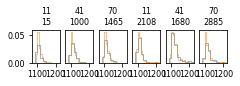

In [6]:
aois = [11, 41, 70, 11, 41, 70]
frames = [15, 1000, 1465, 2108, 1680, 2885]

plt.figure(figsize=(3.5, 0.6))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.title(f"{n}\n{f}", fontsize=8)
    plt.hist(
        model.data[n, f].flatten().numpy(),
        range=(1070, model.data.vmax+50),
        density=True, bins=10, histtype="step", lw=0.5, label="data")
    plt.hist(
        samples["d/data"][0, n, f].flatten().numpy(),
        range=(1070, model.data.vmax+50),
        density=True, bins=20, histtype="step", lw=0.5, label="posterior")
    plt.xlim(1070, model.data.vmax+50)
    plt.xticks([1100, 1200], fontsize=8)
    if i == 0:
        plt.yticks(fontsize=8)
    else:
        plt.yticks([])

# plt.tight_layout()
plt.savefig("/tmp/larrycy3sigma54-hist.svg")

plt.show()

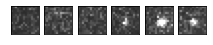

In [33]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    
    plt.imshow(model.data[n, f].numpy(), vmin=1070, vmax=model.data.vmax+50, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

#plt.tight_layout()
plt.savefig("/tmp/larrycy3sigma54-data.png", dpi=600)

plt.show()

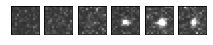

In [34]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.imshow(samples["d/data"][0, n, f].numpy(), vmin=1070, vmax=model.data.vmax+50, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

# plt.tight_layout()
plt.savefig("/tmp/larrycy3sigma54-sample.png", dpi=600)

plt.show()

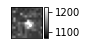

In [35]:
plt.figure(figsize=(0.7, 0.7))

plt.imshow(model.data[n, f].numpy(), vmin=1070, vmax=model.data.vmax+50, cmap="gray")
plt.xticks([], [])
plt.yticks([], [])

#plt.tight_layout()
plt.colorbar(aspect=7, shrink=0.8)
plt.savefig("/tmp/larrycy3sigma54-colorbar.svg")

plt.show()

### Figure 7

In [17]:
data_path = Path("/shared/centaur/data/test/LarryCy3sigma54")
path_params = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs2"

# load parameters
model = Cosmos(S=1, K=2)
# model.load(path_data, True, "cpu")
model.device = torch.device("cpu")
model.data_path = Path(data_path)
model.load_parameters(path_params)

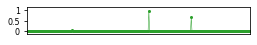

In [18]:
plt.figure(figsize=(4, 0.5))

n = 21
f1 = 0
f2 = 300
plt.plot(
    torch.arange(f1, f2),
    model.z_marginal[n, f1:f2],
    "o-", ms=2, lw=0.5, color="C2", label="fit")

plt.xticks([], fontsize=8)
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
# plt.ylabel(r"$p$", fontsize=8)
# plt.xlabel("frame #")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.legend(fontsize=8)

plt.savefig("/tmp/sigma54-trace.svg")
plt.show()

#### Spotpicker fit

In [8]:
path_data = Path("/shared/centaur/data/test/LarryCy3sigma54")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs2"

# load parameters
model = Cosmos(S=1, K=2)
# model.load(path_data, True, "cpu")
model.device = torch.device("cpu")
model.data_path = Path(path_data)
model.load_parameters(path_params)

test_labels = np.load(path_data / "test_labels.npy")
control_labels = np.load(path_data / "control_labels.npy")

data = time_to_first_binding(test_labels["z"])
data = torch.tensor(data, dtype=torch.float)
control = time_to_first_binding(control_labels["z"])
control = torch.tensor(control, dtype=torch.float)
Tmax = model.z_map.shape[1]

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=data, control=control, Tmax=Tmax
)

In [10]:
from pyro.ops.stats import resample

new_data = resample(data, num_samples=len(data), replacement=True)
new_control = resample(control, num_samples=len(control), replacement=True)

In [13]:
ka = np.array([0.004696997813880444, 0.004969857167452574, 0.003734872443601489, 0.005093452055007219, ])
kns = np.array([5.409849472925998e-05, 4.361174796940759e-05, 5.6516430049669e-05, 6.474168185377494e-05, ])
Af = np.array([0.9070802927017212, 0.8842647075653076, 0.9412854313850403, 0.907416582107544, ])

In [14]:
# 1
new_data = resample(data, num_samples=len(data), replacement=True)
new_control = resample(control, num_samples=len(control), replacement=True)

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=new_data, control=new_control, Tmax=Tmax
)

('ka: 0.031175129115581512', 'kns: 0.006316469982266426', 'Af: 0.3875216245651245')
('ka: 0.020844854414463043', 'kns: 0.004371253773570061', 'Af: 0.3125186264514923')
('ka: 0.015075210481882095', 'kns: 0.0032249914947897196', 'Af: 0.2715817093849182')
('ka: 0.01190467830747366', 'kns: 0.0024901737924665213', 'Af: 0.2576606869697571')
('ka: 0.010197211988270283', 'kns: 0.001988908974453807', 'Af: 0.26737067103385925')
('ka: 0.00915601197630167', 'kns: 0.0016300809802487493', 'Af: 0.3013676702976227')
('ka: 0.008201820775866508', 'kns: 0.0013630329631268978', 'Af: 0.36122846603393555')
('ka: 0.007212459109723568', 'kns: 0.0011578445555642247', 'Af: 0.44328153133392334')
('ka: 0.006407003849744797', 'kns: 0.0009960538009181619', 'Af: 0.5336616039276123')
('ka: 0.005876563489437103', 'kns: 0.0008659037412144244', 'Af: 0.6150192618370056')
('ka: 0.005556882359087467', 'kns: 0.0007595716160722077', 'Af: 0.6786110997200012')
('ka: 0.005366798024624586', 'kns: 0.0006715929484926164', 'Af: 0.7

In [15]:
# 2
new_data = resample(data, num_samples=len(data), replacement=True)
new_control = resample(control, num_samples=len(control), replacement=True)

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=new_data, control=new_control, Tmax=Tmax
)

('ka: 0.030157912522554398', 'kns: 0.006317265331745148', 'Af: 0.3873266875743866')
('ka: 0.01904492825269699', 'kns: 0.004373661708086729', 'Af: 0.31224048137664795')
('ka: 0.013455898500978947', 'kns: 0.0032290352974087', 'Af: 0.2701796889305115')
('ka: 0.010613864287734032', 'kns: 0.0024957440327852964', 'Af: 0.2526935636997223')
('ka: 0.00914845708757639', 'kns: 0.001995889935642481', 'Af: 0.25560516119003296')
('ka: 0.008337641134858131', 'kns: 0.0016383895417675376', 'Af: 0.2789081335067749')
('ka: 0.007651980035007', 'kns: 0.0013726199977099895', 'Af: 0.3247593343257904')
('ka: 0.006780045107007027', 'kns: 0.0011686038924381137', 'Af: 0.39405572414398193')
('ka: 0.005837480537593365', 'kns: 0.0010077257174998522', 'Af: 0.4819476902484894')
('ka: 0.005114730913192034', 'kns: 0.000878065126016736', 'Af: 0.5749127864837646')
('ka: 0.004670674912631512', 'kns: 0.0007718036067672074', 'Af: 0.6570241451263428')
('ka: 0.004409768618643284', 'kns: 0.0006836134707555175', 'Af: 0.72093272

In [16]:
# 3
new_data = resample(data, num_samples=len(data), replacement=True)
new_control = resample(control, num_samples=len(control), replacement=True)

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=new_data, control=new_control, Tmax=Tmax
)

('ka: 0.03152109682559967', 'kns: 0.0063173286616802216', 'Af: 0.3895467221736908')
('ka: 0.022287361323833466', 'kns: 0.0043739331886172295', 'Af: 0.3216627538204193')
('ka: 0.017752481624484062', 'kns: 0.003229306312277913', 'Af: 0.29181569814682007')
('ka: 0.015485754236578941', 'kns: 0.002495578723028302', 'Af: 0.2934134900569916')
('ka: 0.01386096142232418', 'kns: 0.001994792837649584', 'Af: 0.32402682304382324')
('ka: 0.011999547481536865', 'kns: 0.0016359383007511497', 'Af: 0.3827452063560486')
('ka: 0.010182222351431847', 'kns: 0.0013685810845345259', 'Af: 0.46324288845062256')
('ka: 0.00883897952735424', 'kns: 0.0011631501838564873', 'Af: 0.5486444234848022')
('ka: 0.007930864579975605', 'kns: 0.001001480151899159', 'Af: 0.622769296169281')
('ka: 0.007333563640713692', 'kns: 0.0008718133321963251', 'Af: 0.6804296970367432')
('ka: 0.0069483425468206406', 'kns: 0.0007661728304810822', 'Af: 0.7233065962791443')
('ka: 0.006697234697639942', 'kns: 0.0006789384642615914', 'Af: 0.754

In [17]:
# 4
new_data = resample(data, num_samples=len(data), replacement=True)
new_control = resample(control, num_samples=len(control), replacement=True)

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=new_data, control=new_control, Tmax=Tmax
)

('ka: 0.03083430603146553', 'kns: 0.00631758151575923', 'Af: 0.38795602321624756')
('ka: 0.02001255750656128', 'kns: 0.0043746610172092915', 'Af: 0.31519654393196106')
('ka: 0.014109820127487183', 'kns: 0.0032305261120200157', 'Af: 0.27884232997894287')
('ka: 0.01104661263525486', 'kns: 0.002497396431863308', 'Af: 0.2721913456916809')
('ka: 0.009465483948588371', 'kns: 0.001997285522520542', 'Af: 0.2929413616657257')
('ka: 0.008418374694883823', 'kns: 0.0016390583477914333', 'Af: 0.34290850162506104')
('ka: 0.007339070085436106', 'kns: 0.0013721154537051916', 'Af: 0.4225409924983978')
('ka: 0.006301560439169407', 'kns: 0.001166656264103949', 'Af: 0.5228220224380493')
('ka: 0.005584715865552425', 'kns: 0.0010044347727671266', 'Af: 0.6235231757164001')
('ka: 0.005184115841984749', 'kns: 0.000873867713380605', 'Af: 0.7067998051643372')
('ka: 0.004970466252416372', 'kns: 0.000767216959502548', 'Af: 0.7681687474250793')
('ka: 0.004852506332099438', 'kns: 0.000679027521982789', 'Af: 0.811561

In [18]:
# 5
new_data = resample(data, num_samples=len(data), replacement=True)
new_control = resample(control, num_samples=len(control), replacement=True)

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=new_data, control=new_control, Tmax=Tmax
)

('ka: 0.03046063333749771', 'kns: 0.006316973362118006', 'Af: 0.3873690366744995')
('ka: 0.018778832629323006', 'kns: 0.0043726712465286255', 'Af: 0.3132069408893585')
('ka: 0.0125731211155653', 'kns: 0.0032271789386868477', 'Af: 0.27566251158714294')
('ka: 0.009783853776752949', 'kns: 0.0024929954670369625', 'Af: 0.26643866300582886')
('ka: 0.008728491142392159', 'kns: 0.001992203528061509', 'Af: 0.2809750735759735')
('ka: 0.008320475928485394', 'kns: 0.0016336479457095265', 'Af: 0.319451242685318')
('ka: 0.007865923456847668', 'kns: 0.0013667478924617171', 'Af: 0.38184043765068054')
('ka: 0.007278683129698038', 'kns: 0.0011617024429142475', 'Af: 0.46129110455513')
('ka: 0.006758924573659897', 'kns: 0.0010001763002946973', 'Af: 0.5426877737045288')
('ka: 0.006386993918567896', 'kns: 0.0008704222273081541', 'Af: 0.6123179197311401')
('ka: 0.006144816521555185', 'kns: 0.0007645754376426339', 'Af: 0.665503203868866')
('ka: 0.005990542937070131', 'kns: 0.0006771017797291279', 'Af: 0.70408

In [5]:
# Tmax = model.data.F
nz = sum(data == 0)
n = sum(data == Tmax)
N = len(data)
tau = data[(data > 0) & (data < Tmax)]

nzc = sum(control == 0)
nc = sum(control == Tmax)
Nc = len(control)
tauc = control[(control > 0) & (control < Tmax)]

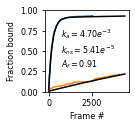

In [7]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(Tmax)
plt.plot(sorted(data[data < Tmax]), np.arange(1, N+1-n) / N)
plt.plot(sorted(control[control < Tmax]), np.arange(1, Nc+1-nc) / Nc)
plt.plot(
    x,
    nzc / Nc +
    (1 - nzc / Nc) *
    (1 - np.exp(-pyro.param("kns").item() * x)),
    color="k"
)
plt.plot(
    x,
    nz / N +
    (1 - nz / N) *
    (pyro.param("Af").item()*(1 - np.exp(-(pyro.param("ka")+pyro.param("kns")).item() * x)) +
    (1 - pyro.param("Af").item())*(1 - np.exp(-pyro.param("kns").item() * x))),
    color="k"
)
plt.text(
    700, 0.3,
    s="$k_a = 4.70e^{-3}$\n$k_{ns} = 5.41e^{-5}$\n$A_f = 0.91$",
    fontsize=8
)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Frame #", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
plt.savefig("/tmp/larrycy3sigma54-spotpicker.svg")
plt.show()

#### Spotpicker w/o control

In [11]:
path_data = Path("/shared/centaur/data/test/LarryCy3sigma54")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs2"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

data = time_to_first_binding(model.data.labels["z"])
data = torch.tensor(data, dtype=torch.float)
control = None
Tmax = model.data.F

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=data, control=control, Tmax=Tmax
)

('ka: 0.030598808079957962', 'kns: 0.006358620710670948', 'Af: 0.3879767060279846')
('ka: 0.019817790016531944', 'kns: 0.004502575378865004', 'Af: 0.3148513734340668')
('ka: 0.014188142493367195', 'kns: 0.0034434550907462835', 'Af: 0.27584773302078247')
('ka: 0.011317411437630653', 'kns: 0.002783627714961767', 'Af: 0.2618943154811859')
('ka: 0.0098906010389328', 'kns: 0.0023429198190569878', 'Af: 0.2676052749156952')
('ka: 0.009162562899291515', 'kns: 0.0020291716791689396', 'Af: 0.29117125272750854')
('ka: 0.008630623109638691', 'kns: 0.001790981157682836', 'Af: 0.3321371078491211')
('ka: 0.008018150925636292', 'kns: 0.00159837631508708', 'Af: 0.3888183832168579')
('ka: 0.007336253300309181', 'kns: 0.001434069825336337', 'Af: 0.45631834864616394')
('ka: 0.00671836081892252', 'kns: 0.0012890046928077936', 'Af: 0.5265890955924988')
('ka: 0.006236109416931868', 'kns: 0.0011592819355428219', 'Af: 0.5916279554367065')
('ka: 0.005888799205422401', 'kns: 0.0010434772120788693', 'Af: 0.646848

('ka: 0.004739496856927872', 'kns: 7.32194894226268e-05', 'Af: 0.9034643769264221')
('ka: 0.004739494528621435', 'kns: 7.321920566027984e-05', 'Af: 0.9034644961357117')
('ka: 0.004739494528621435', 'kns: 7.321900193346664e-05', 'Af: 0.9034644961357117')


In [12]:
data = time_to_first_binding(model.data.labels["z"])
Tmax = model.data.F
nz = sum(data == 0)
n = sum(data == Tmax)
N = len(data)
tau = data[(data > 0) & (data < Tmax)]

control = time_to_first_binding(model.control.labels["z"])
nzc = sum(control == 0)
nc = sum(control == Tmax)
Nc = len(control)
tauc = control[(control > 0) & (control < Tmax)]

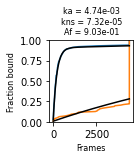

In [13]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(model.data.F)
plt.plot(sorted(data), np.arange(1, N+1) / N)
plt.plot(sorted(control), np.arange(1, Nc+1) / Nc)
plt.plot(
    x,
    nzc / Nc +
    (1 - nzc / Nc) *
    (1 - np.exp(-pyro.param("kns").item() * x)),
    color="k"
)
plt.plot(
    x,
    nz / N +
    (1 - nz / N) *
    (pyro.param("Af").item()*(1 - np.exp(-(pyro.param("ka")+pyro.param("kns")).item() * x)) +
    (1 - pyro.param("Af").item())*(1 - np.exp(-pyro.param("kns").item() * x))),
    color="k"
)
plt.title(
    f"ka = {pyro.param('ka').item():.2e}\nkns = {pyro.param('kns').item():.2e}\nAf = {pyro.param('Af').item():.2e}",
    fontsize=8
)
plt.xlabel("Frames", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
plt.savefig("/tmp/larrycy3sigma54-sp.svg")
plt.show()

#### Tapqir fit

In [2]:
path_data = Path("/shared/centaur/data/test/LarryCy3sigma54")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs2"

# load parameters
model = Cosmos(S=1, K=2)
# model.load(path_data, True, "cpu")
model.device = torch.device("cpu")
model.data_path = Path(path_data)
model.load_parameters(path_params)

data = time_to_first_binding(model.z_map)
z_marginal = model.z_marginal.data
control = None
Tmax = model.z_map.shape[1]

train(
    ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
    data=data, control=control, Tmax=Tmax
)

ka = []
kns = []
Af = []
ka.append(pyro.param("ka").item())
kns.append(pyro.param("kns").item())
Af.append(pyro.param("Af").item())

In [3]:
for i in range(100):
    z = dist.Bernoulli(z_marginal).sample()
    data = time_to_first_binding(z)

    train(
        ttfb_model, ttfb_guide, lr=5e-3, n_steps=10000,
        data=data, control=control, Tmax=Tmax
    )
    ka.append(pyro.param("ka").item())
    kns.append(pyro.param("kns").item())
    Af.append(pyro.param("Af").item())

In [4]:
# ka
tapqir_ka = np.array(ka)
tapqir_ka.mean(), np.quantile(tapqir_ka, 0.16), np.quantile(tapqir_ka, 0.84)

(0.006398505171631822, 0.0058924537152051926, 0.006795655470341444)

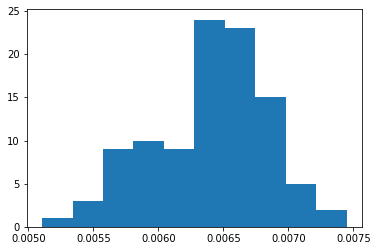

In [9]:
plt.hist(tapqir_ka)
plt.show()

In [5]:
# kns
tapqir_kns = np.array(kns)
tapqir_kns.mean(), np.quantile(tapqir_kns, 0.16), np.quantile(tapqir_kns, 0.84)

(0.0005387704995072373, 0.0003745276480913162, 0.0007311510271392763)

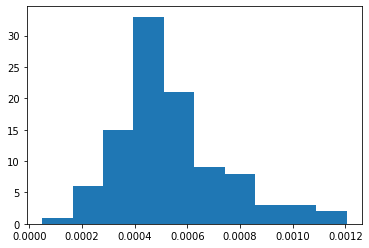

In [10]:
plt.hist(tapqir_kns)
plt.show()

In [6]:
# Af
tapqir_Af = np.array(Af)
tapqir_Af.mean(), np.quantile(tapqir_Af, 0.16), np.quantile(tapqir_Af, 0.84)

(0.8706523463277533, 0.8442452549934387, 0.9009965658187866)

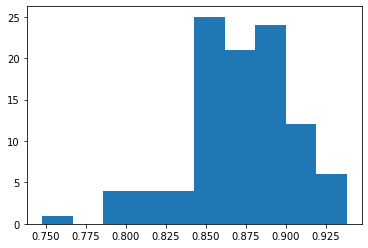

In [11]:
plt.hist(tapqir_Af)
plt.show()

In [60]:
# Tmax = model.z_map.shape[1]
nz = sum(data == 0)
n = sum(data == Tmax)
N = len(data)
tau = data[(data > 0) & (data < Tmax)]

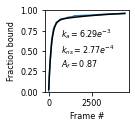

In [61]:
plt.figure(figsize=(1.5, 1.5))
x = torch.arange(Tmax)
plt.plot(sorted(data[data < Tmax]), np.arange(1, N+1-n) / N)
plt.plot(
    x,
    nz / N +
    (1 - nz / N) *
    (pyro.param("Af").item()*(1 - np.exp(-(pyro.param("ka")+pyro.param("kns")).item() * x)) +
    (1 - pyro.param("Af").item())*(1 - np.exp(-pyro.param("kns").item() * x))),
    color="k", label=""
)
plt.text(
    700, 0.3,
    s="$k_a = 6.29e^{-3}$\n$k_{ns} = 2.77e^{-4}$\n$A_f = 0.87$",
    fontsize=8
)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Frame #", fontsize=8)
plt.ylabel("Fraction bound", fontsize=8)
plt.ylim(0, 1)
plt.savefig("/tmp/larrycy3sigma54-tapqir.svg")
plt.show()

In [18]:
path_data = Path("/shared/centaur/data/test/LarryCy3sigma54")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs2"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

dt = unbound_dwell_times(count_intervals(model.z_map))
dt = torch.tensor(dt, dtype=torch.float)

train(
    double_exp_model, double_exp_guide, lr=5e-3, n_steps=5000,
    data=dt
)

('k1: 0.06326863914728165', 'k2: 0.806296169757843', 'A: 0.3972044289112091')
('k1: 0.04403289780020714', 'k2: 0.805378258228302', 'A: 0.35675185918807983')
('k1: 0.03276247903704643', 'k2: 0.7930259704589844', 'A: 0.36209964752197266')
('k1: 0.02556515671312809', 'k2: 0.7782955169677734', 'A: 0.3823828399181366')
('k1: 0.02067655511200428', 'k2: 0.7655236124992371', 'A: 0.3994747996330261')
('k1: 0.01719934679567814', 'k2: 0.7550943493843079', 'A: 0.4110684394836426')
('k1: 0.014635416679084301', 'k2: 0.746364951133728', 'A: 0.41918694972991943')
('k1: 0.012689588591456413', 'k2: 0.7388710975646973', 'A: 0.42523637413978577')
('k1: 0.011177897453308105', 'k2: 0.7323359251022339', 'A: 0.42993685603141785')
('k1: 0.009980653412640095', 'k2: 0.7265782356262207', 'A: 0.43369415402412415')
('k1: 0.009017259813845158', 'k2: 0.7214694619178772', 'A: 0.4367603659629822')
('k1: 0.008231759071350098', 'k2: 0.7169142961502075', 'A: 0.4393025040626526')
('k1: 0.00758421840146184', 'k2: 0.71283954

No handles with labels found to put in legend.


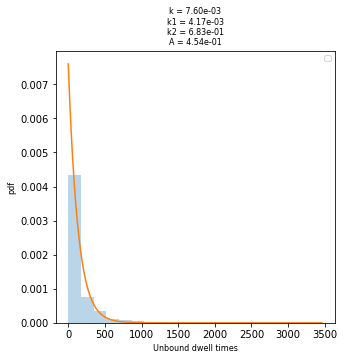

In [19]:
k = 1 / dt.mean()

plt.figure(figsize=(5, 5))
plt.title(
    f"k = {k:.2e}\nk1 = {pyro.param('k1').item():.2e}\nk2 = {pyro.param('k2').item():.2e}\nA = {pyro.param('A').item():.2e}",
    fontsize=8
)

plt.hist(dt.numpy(), bins=20, density=True, alpha=0.3)
x = torch.arange(0.01, dt.max())
d = dist.Exponential(k)
plt.plot(x, d.log_prob(x).exp())
d1 = (1 - pyro.param("A").item())*(dist.Exponential(pyro.param("k1").item()).log_prob(x)).exp()
d2 = pyro.param("A").item()*(dist.Exponential(pyro.param("k2").item()).log_prob(x)).exp()
#plt.plot(x, d1, label="A1")
#plt.plot(x, d2, label="A2")
#plt.plot(x, d1+d2, label="At")
plt.xlabel("Unbound dwell times", fontsize=8)
plt.ylabel("pdf", fontsize=8)
#plt.ylim(0, 0.2)
#plt.xlim(0, 100)
plt.legend(fontsize=8)
plt.savefig("/tmp/larrycy3sigma54-kon.svg")
plt.show()

In [20]:
path_data = Path("/shared/centaur/data/test/LarryCy3sigma54")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs2"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

dt = bound_dwell_times(count_intervals(model.z_map))
dt = torch.tensor(dt, dtype=torch.float)

train(
    double_exp_model, double_exp_guide, lr=5e-3, n_steps=5000,
    data=dt
)

('k1: 0.0645720362663269', 'k2: 0.6512196063995361', 'A: 0.4503961205482483')
('k1: 0.047051720321178436', 'k2: 0.48807814717292786', 'A: 0.5551512241363525')
('k1: 0.03657902777194977', 'k2: 0.40520092844963074', 'A: 0.6441272497177124')
('k1: 0.029911402612924576', 'k2: 0.3657234013080597', 'A: 0.6949074268341064')
('k1: 0.025532519444823265', 'k2: 0.3450435400009155', 'A: 0.7233957052230835')
('k1: 0.022572163492441177', 'k2: 0.3323234021663666', 'A: 0.7409130334854126')
('k1: 0.020519409328699112', 'k2: 0.32362526655197144', 'A: 0.7526230216026306')
('k1: 0.01906970888376236', 'k2: 0.31738609075546265', 'A: 0.7608195543289185')
('k1: 0.01803519017994404', 'k2: 0.3128315806388855', 'A: 0.7666791677474976')
('k1: 0.017294613644480705', 'k2: 0.3094986379146576', 'A: 0.7708964347839355')
('k1: 0.016766158863902092', 'k2: 0.30707529187202454', 'A: 0.7739240527153015')
('k1: 0.016392523422837257', 'k2: 0.30533599853515625', 'A: 0.7760767340660095')
('k1: 0.016131995245814323', 'k2: 0.304

In [ ]:
k = 1 / dt.mean()

plt.figure(figsize=(5, 5))
plt.title(
    f"k = {k:.2e}\nk1 = {pyro.param('k1').item():.2e}\nk2 = {pyro.param('k2').item():.2e}\nA = {pyro.param('A').item():.2e}",
    fontsize=8
)

plt.hist(dt.numpy(), bins=20, density=True, alpha=0.3)
x = torch.arange(0.01, dt.max())
d = dist.Exponential(k)
plt.plot(x, d.log_prob(x).exp())
d1 = (1 - pyro.param("A").item())*(dist.Exponential(pyro.param("k1").item()).log_prob(x)).exp()
d2 = pyro.param("A").item()*(dist.Exponential(pyro.param("k2").item()).log_prob(x)).exp()
#plt.plot(x, d1, label="A1")
#plt.plot(x, d2, label="A2")
#plt.plot(x, d1+d2, label="At")
plt.xlabel("Unbound dwell times", fontsize=8)
plt.ylabel("pdf", fontsize=8)
#plt.ylim(0, 0.2)
#plt.xlim(0, 100)
plt.legend(fontsize=8)
plt.savefig("/tmp/larrycy3sigma54-koff.svg")
plt.show()

#### Rastegram

In [ ]:
model.

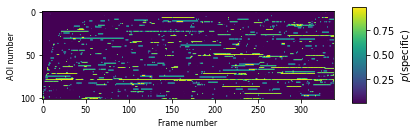

In [74]:
path_data = Path("/shared/centaur/data/test/LarryCy3sigma54")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs2"

# load parameters
model = Cosmos(S=1, K=2)
# model.load(path_data, True, "cpu")
model.device = torch.device("cpu")
model.data_path = Path(path_data)
model.load_parameters(path_params)

ttfb = time_to_first_binding(model.z_map)
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)


plt.figure(figsize=(6, 2))
plt.imshow(model.z_marginal[sdx][:, ::13], aspect="equal")
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.xlabel("Frame number", fontsize=8)
plt.ylabel("AOI number", fontsize=8)
plt.colorbar(aspect=7, shrink=0.9, label=r"$p(\mathsf{specific})$")
plt.tight_layout()
plt.savefig("/tmp/larrycy3sigma54-rastegram.png", dpi=900)
plt.show()

In [66]:
model.z_probs.shape

torch.Size([2, 102, 4407])

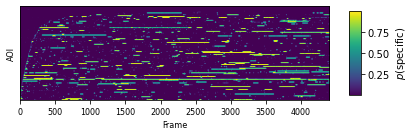

In [64]:
path_data = Path("/shared/centaur/data/test/LarryCy3sigma54")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs2"

# load parameters
model = Cosmos(S=1, K=2)
# model.load(path_data, True, "cpu")
model.device = torch.device("cpu")
model.data_path = Path(path_data)
model.load_parameters(path_params)

ttfb = time_to_first_binding(model.z_map)
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)


plt.figure(figsize=(6, 2))
plt.imshow(model.z_marginal[sdx], aspect="auto")
plt.yticks([])
plt.xticks(fontsize=8)
plt.xlabel("Frame", fontsize=8)
plt.ylabel("AOI", fontsize=8)
plt.colorbar(aspect=7, shrink=0.9, label=r"$p(\mathsf{specific})$")
plt.tight_layout()
plt.savefig("/tmp/larrycy3sigma54-rastegram.png", dpi=900)
plt.show()

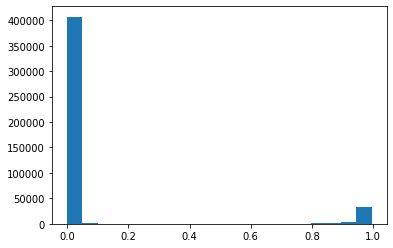

In [56]:
plt.hist(model.z_marginal.numpy().ravel(), bins=20)
plt.show()

In [36]:
plt.figure(figsize=(0.7, 0.7))

#plt.imshow(model.data[n, f].numpy(), vmin=120, vmax=model.data.vmax+150, cmap="gray")
#plt.xticks([], [])
#plt.yticks([], [])

plt.colorbar(aspect=7, shrink=0.8)
# plt.savefig("/tmp/height-colorbar.svg")

plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 50.4x50.4 with 0 Axes>

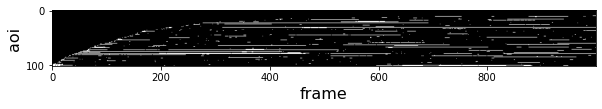

In [22]:
path_data = Path("/shared/centaur/data/test/LarryCy3sigma54")
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs2"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

ttfb = time_to_first_binding(model.z_map)
# sort ttfb
sdx = torch.argsort(ttfb, descending=True)


figsize = torch.tensor([10, 10 * model.data.N / 1000])
plt.figure(figsize=figsize)
plt.imshow(model.z_map[sdx][:, :1000], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

#### Spotpicker analysis

0.00026095658052359806


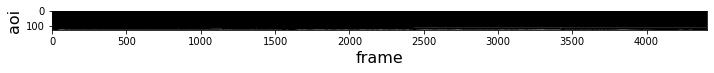

In [8]:
frames = np.arange(1, model.control.F+1)
q1 = np.ones((model.control.N, model.control.F))
q1[:, :-1] = model.control.labels["z"][:, 1:]
cumq0 = np.cumprod(1 - model.control.labels["z"], axis=-1)
sttfb = (frames * q1 * cumq0).sum(-1)
print(1/sttfb.mean())
sdx = np.flip(np.argsort(sttfb))

plt.figure(figsize=figsize)

plt.imshow(model.control.labels["z"][sdx], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

In [10]:
Tmax = model.control.F
nc = sum(sttfb == Tmax)
Nc = model.control.N
tauc = torch.tensor(sttfb[sttfb < Tmax])
kns = (Nc - nc) / (nc*Tmax + sum(tauc))

In [24]:
kns

tensor(5.5479e-05, dtype=torch.float64)

0.0019062213833186939


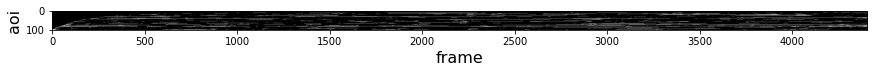

In [14]:
frames = np.arange(1, model.data.F+1)
q1 = np.ones((model.data.N, model.data.F))
q1[:, :-1] = model.data.labels["z"][:, 1:]
cumq0 = np.cumprod(1 - model.data.labels["z"], axis=-1)
sttfb = (frames * q1 * cumq0).sum(-1)
print(1/sttfb.mean())
sdx = np.flip(np.argsort(sttfb))

plt.figure(figsize=figsize)

plt.imshow(model.data.labels["z"][sdx], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

In [15]:
Tmax = model.data.F
n = sum(sttfb == Tmax)
nz = sum(sttfb == 0)
N = model.data.N
tau = torch.tensor(sttfb[(sttfb < Tmax) & (sttfb > 0)])

In [50]:
torch.logsumexp(torch.stack([torch.tensor(0.3), torch.tensor(0.5)]), dim=0)

tensor(1.0981)

In [16]:
def ll(k, a):
    result = n * torch.log((a - nz/N) * torch.exp(-(k+kns) * Tmax) + (1-a)*math.exp(-kns*Tmax)) \
    + torch.sum(torch.log((a-nz/N)*(k+kns)*torch.exp(-(k+kns)*tau)+(1-a)*kns*torch.exp(-kns*tau)))
    return result

lr = 1e-4
kon = torch.tensor(0.01, requires_grad=True)
Af = torch.tensor(0.5, requires_grad=True)
optimizer = torch.optim.Adam((kon,Af), lr=lr)

In [21]:
for t in range(2000):

    # Compute and print loss.
    loss = -ll(kon, Af)
    if t % 100 == 99:
        print(t, loss.item(), kon.item(), Af.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

99 623.4156625724346 0.004700407851487398 0.9095473289489746
199 623.415662182122 0.004700405523180962 0.9095474481582642
299 623.4156623329817 0.0047004041261971 0.9095476269721985
399 623.4156626790038 0.004700407385826111 0.909547746181488
499 623.4156622887416 0.004700405988842249 0.9095478653907776
599 623.4156626348313 0.004700400400906801 0.9095479846000671
699 623.4156683251011 0.004698481876403093 0.9095485806465149
799 623.4156625968925 0.004700265824794769 0.909549355506897
899 623.4156774765895 0.004703391343355179 0.909549355506897
999 623.4156626973837 0.004700521007180214 0.9095497727394104
1099 623.4156626837873 0.004700480028986931 0.9095497727394104
1199 623.4156629820402 0.004700707737356424 0.9095499515533447
1299 623.4156628291947 0.00470045255497098 0.9095499515533447
1399 623.4156625149773 0.004700619727373123 0.9095500707626343
1499 623.4156624348193 0.004700393415987492 0.9095500707626343
1599 623.4156626365674 0.00469991285353899 0.909550130367279
1699 623.415

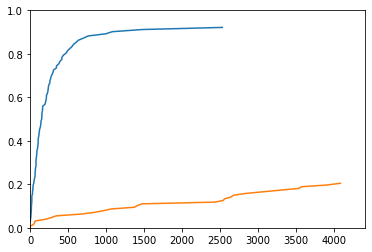

In [23]:
plt.plot(sorted(tau), (nz + np.arange(N - n - nz)) / N)
plt.plot(sorted(tauc), np.arange(Nc - nc) / Nc)
plt.xlim(0, model.data.F)
plt.ylim(0, 1)
plt.show()

View target DNA sites

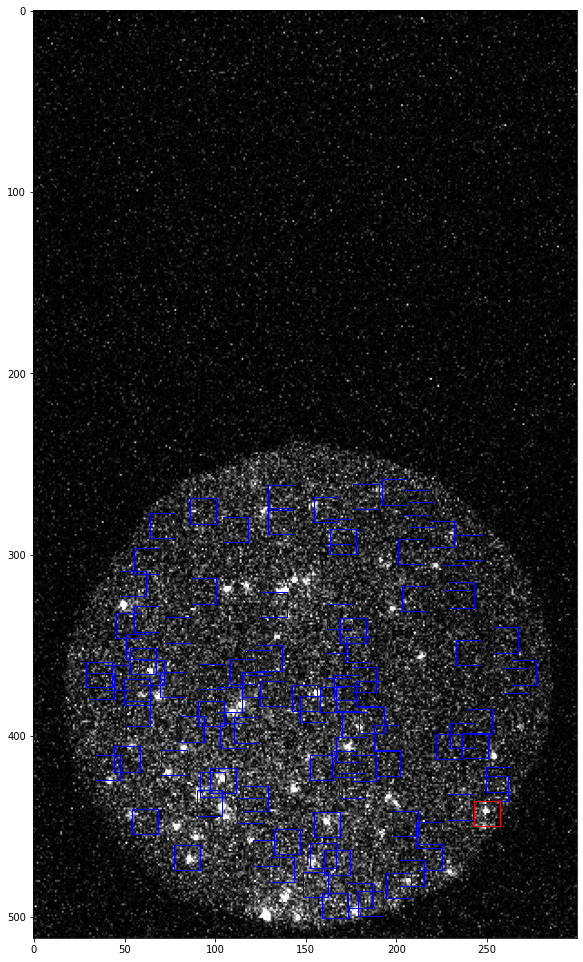

In [3]:
frame = data.drift.index[5]
plt.figure(figsize=(10, 10*glimpse.height/glimpse.width))
plt.imshow(glimpse[frame], cmap="gray", vmin=data.vmin, vmax=data.vmax)

for n in data.target.index:
    y_pos = data.target.at[n, "abs_y"] + data.drift.at[frame, "abs_dy"] - 7
    x_pos = data.target.at[n, "abs_x"] + data.drift.at[frame, "abs_dx"] - 7
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14, edgecolor="b", facecolor="none"))
    #plt.gca().text(y_pos, x_pos, str(n), fontsize=10, color="white")

aoi = data.target.index[4]  
y_pos = data.target.at[aoi, "abs_y"] + data.drift.at[frame, "abs_dy"] - 7
x_pos = data.target.at[aoi, "abs_x"] + data.drift.at[frame, "abs_dx"] - 7
plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14, edgecolor="r", facecolor="none"))
plt.show()

View non DNA sites

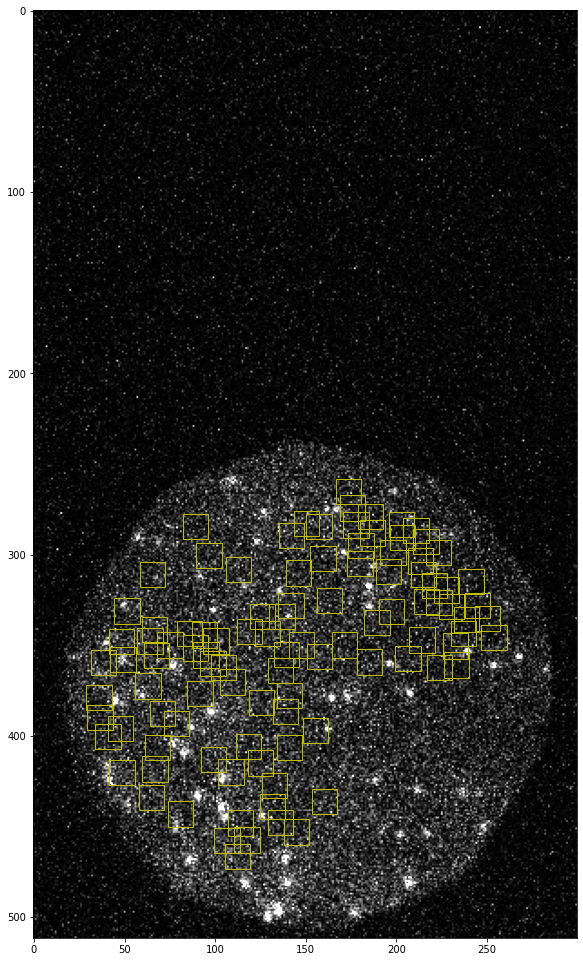

In [4]:
frame = data.drift.index[105]
plt.figure(figsize=(10, 10*glimpse.height/glimpse.width))
plt.imshow(glimpse[frame], cmap="gray", vmin=data.vmin, vmax=data.vmax)

for n in data.target.index:
    y_pos = control.target.at[n, "abs_y"] + control.drift.at[frame, "abs_dy"] - 7
    x_pos = control.target.at[n, "abs_x"] + control.drift.at[frame, "abs_dx"] - 7
    plt.gca().add_patch(Rectangle((y_pos, x_pos), 14, 14, edgecolor="y", facecolor="none"))

plt.show()

## Load parameters

In [3]:
path_params = os.path.join(path_data, "runs/cosmos/v1.1.6/S1/nocontrol/lr0.005/bs2")
# load global parameters
results = pd.read_csv(
    os.path.join(path_params, "global_params.csv"),
    header=None, squeeze=True, index_col=0)
# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)
# load spotpicker labels
labels = np.load(os.path.join(path_data, "labels.npy"))

In [4]:
predictive = Predictive(pyro.poutine.uncondition(model.model), guide=model.guide, num_samples=1)
samples = predictive()

## Analysis

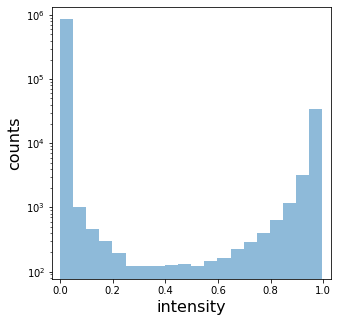

In [5]:
plt.figure(figsize=(5,5))
plt.hist(model.z_probs.flatten().numpy(),
         bins=20, alpha=0.5)
plt.yscale("log")
#plt.ylim(0,50000)
plt.xlim(-0.03,1.03)
plt.ylabel("counts", fontsize=16)
plt.xlabel("intensity", fontsize=16)
plt.show()

### Intensity analysis

Intensity histogram (on-target spots)

In [ ]:
# create data
x = param("d/h_loc").data.flatten().numpy()
y = model.m_probs.flatten().numpy()
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=300
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.show()

In [ ]:
model.m_probs.flatten().numpy().shape

In [32]:
mask = samples["d/m_0"] == 1
samples["d/height_0"][mask]

tensor([ 795.5239,  270.1296,  362.0681,  ...,  720.3281, 1059.0697,
         747.7330], grad_fn=<IndexBackward>)

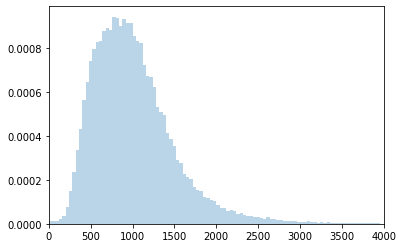

In [37]:
mask = samples["d/m_0"] == 1

plt.hist(
    samples["d/height_0"][mask].data.numpy(),
    bins=100, range=(0,4000),
    density=True, alpha=0.3)
#plt.yscale("log")
plt.xlim(0,4000)
plt.show()

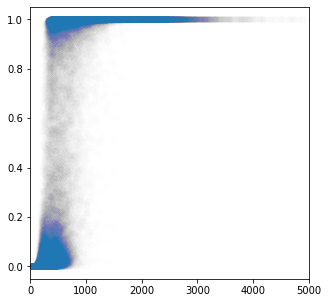

In [17]:
plt.figure(figsize=(5,5))
#colors = np.zeros((model.K*model.data.N*model.data.F, 4))
#colors += to_rgba_array("C2")
#colors[:, 3] = model.m_probs.flatten()
plt.scatter(param("d/h_loc").data.flatten(), model.m_probs.flatten(), alpha=0.005)
plt.xlim(0,5000)
plt.show()

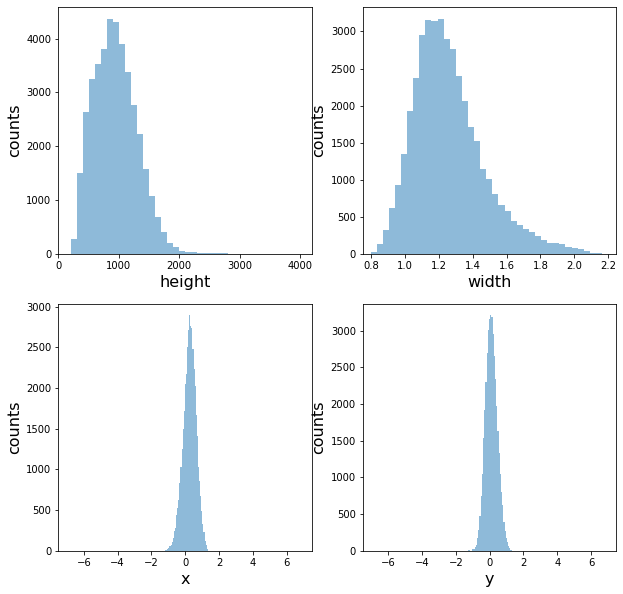

In [8]:
plt.figure(figsize=(10,10))
mask = model.z_probs > 0.5
plt.subplot(2,2,1)
plt.hist(param("d/h_loc").data[mask].numpy(),
         range=(0,4000), bins=40, alpha=0.5)
plt.xlim(0,)
plt.ylabel("counts", fontsize=16)
plt.xlabel("height", fontsize=16)

plt.subplot(2,2,2)
plt.hist(param("d/w_mean").data[mask].numpy(),
         bins=40, alpha=0.5)
plt.xlim(0.75,2.25)
plt.ylabel("counts", fontsize=16)
plt.xlabel("width", fontsize=16)

plt.subplot(2,2,3)
plt.hist(param("d/x_mean").data[mask].numpy(),
         bins=40, alpha=0.5)
plt.xlim(-7.5,7.5)
plt.ylabel("counts", fontsize=16)
plt.xlabel("x", fontsize=16)

plt.subplot(2,2,4)
plt.hist(param("d/y_mean").data[mask].numpy(),
         bins=40, alpha=0.5)
plt.xlim(-7.5,7.5)
plt.ylabel("counts", fontsize=16)
plt.xlabel("y", fontsize=16)
plt.show()

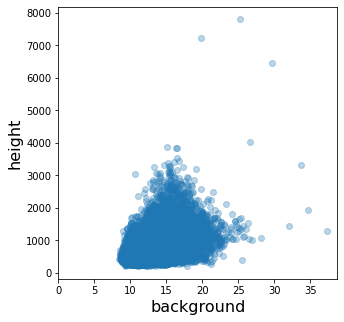

In [9]:
plt.figure(figsize=(5,5))
mask = model.z_probs > 0.5
plt.scatter(param("d/b_loc").data[mask.sum(0).bool()].numpy(), param("d/h_loc").data[mask].numpy(), alpha=0.3)
plt.xlim(0,)
plt.ylabel("height", fontsize=16)
plt.xlabel("background", fontsize=16)
plt.show()

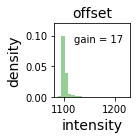

In [76]:
plt.figure(figsize=(1.35,1.35))
plt.hist(
        model.data.offset.flatten().numpy(),
        range=(model.data.vmin-10, model.data.vmax+50),
        density=True, bins=20, alpha=0.5, color="C2", label="offset")
plt.text(1120, 0.09, "gain = 17")
plt.title("offset", fontsize=14)
plt.ylabel("density", fontsize=14)
plt.xlabel("intensity", fontsize=14)
plt.ylim(0,0.12)
#plt.legend()
#plt.tight_layout()
plt.show()

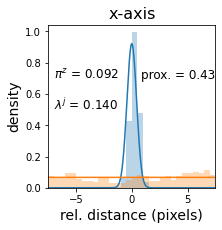

In [112]:
plt.figure(figsize=(3,3))

plt.hist(param("d/x_mean").data.flatten().numpy(),
         weights=model.z_probs.flatten().numpy(), density=True,
         range=(-7.5, 7.5), bins=30, alpha=0.3)
plt.hist(param("d/x_mean").data.flatten().numpy(),
         weights=model.j_probs.flatten().numpy(), density=True,
         range=(-7.5, 7.5), bins=30, alpha=0.3)

x = torch.arange(-7.5,7.5, 0.01)
size = (((model.data.D+1)/(2*param("proximity").data))**2-1)
d = AffineBeta(0., size, -7.5, 7.5)
d2 = AffineBeta(0., 2., -7.5, 7.5)
plt.plot(x, d.log_prob(x).exp(), color="C0", label="on-target")
plt.plot(x, d2.log_prob(x).exp(), color="C1", label="off-target")


plt.text(0.8, 0.7, "prox. = {:.2f}".format(param("proximity").item()),
         fontsize=12)
plt.text(-7, 0.7, r"$\pi^z$ = {:.3f}".format(param("probs_z")[1].item()),
         fontsize=12)
plt.text(-7, 0.5, r"$\lambda^j$ = {:.3f}".format(param("rate_j").item()),
         fontsize=12)

plt.ylabel("density", fontsize=14)
plt.xlabel("rel. distance (pixels)", fontsize=14)
plt.title("x-axis", fontsize=16)
plt.xlim(-7.5, 7.5)
#plt.legend(fontsize=12)
plt.show()

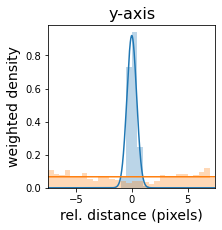

In [113]:
plt.figure(figsize=(3,3))

plt.hist(param("d/y_mean").data.flatten().numpy(),
         weights=model.z_probs.flatten().numpy(), density=True,
         range=(-7.5, 7.5), bins=30, alpha=0.3)
plt.hist(param("d/y_mean").data.flatten().numpy(),
         weights=model.j_probs.flatten().numpy(), density=True,
         range=(-7.5, 7.5), bins=30, alpha=0.3)

x = torch.arange(-7.5,7.5, 0.01)
size = (((model.data.D+1)/(2*param("proximity").data))**2-1)
d = AffineBeta(0., size, -7.5, 7.5)
d2 = AffineBeta(0., 2., -7.5, 7.5)
plt.plot(x, d.log_prob(x).exp(), color="C0", label="on-target")
plt.plot(x, d2.log_prob(x).exp(), color="C1", label="off-target")

plt.ylabel("weighted density", fontsize=14)
plt.xlabel("rel. distance (pixels)", fontsize=14)
plt.title("y-axis", fontsize=16)
plt.xlim(-7.5, 7.5)
#plt.legend(fontsize=12)
plt.show()

### Binding rastergram

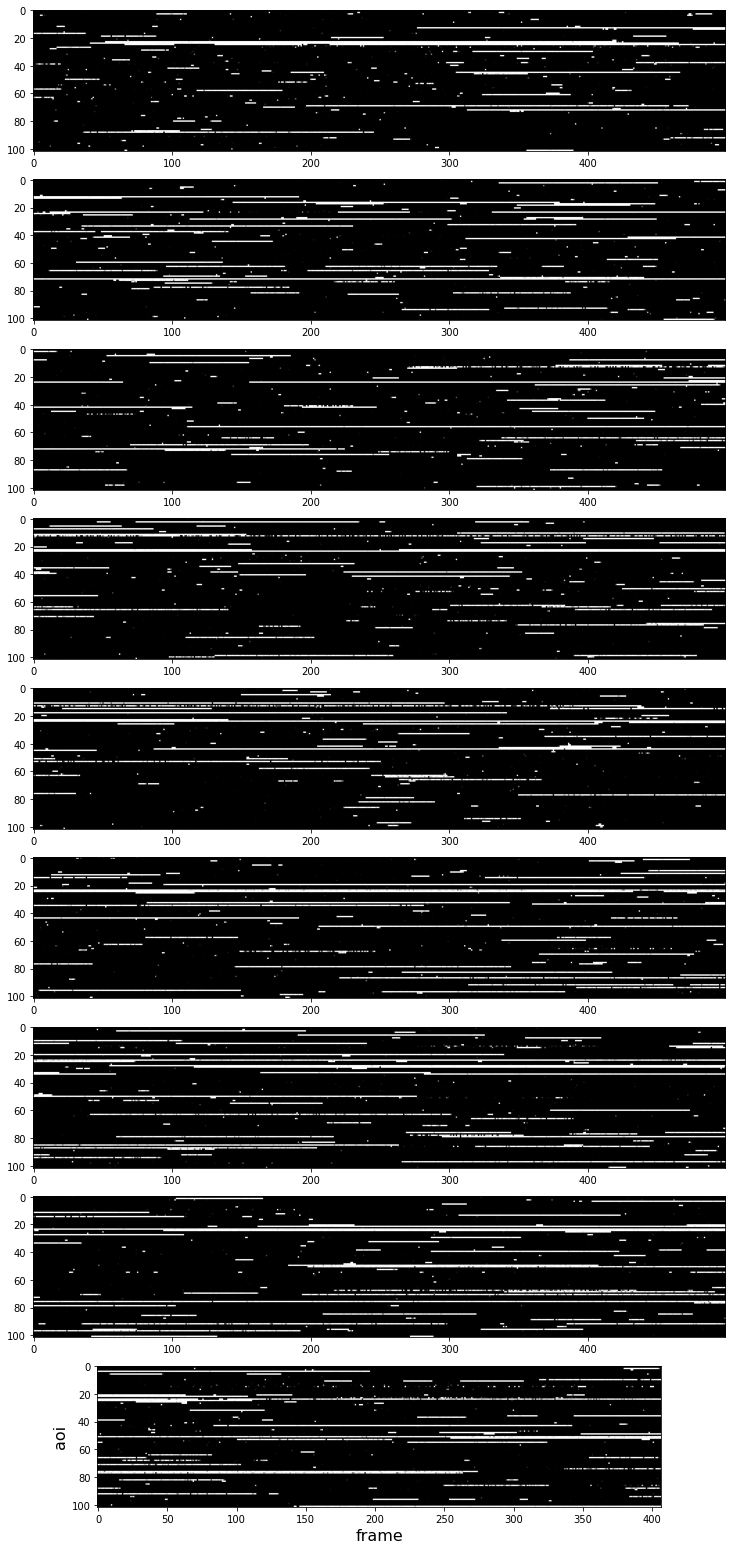

In [11]:
r = model.data.F // 500 + 1
figsize = torch.tensor([15, model.data.N * r * 15. / 500])
plt.figure(figsize=figsize)
for i in range(r):
    plt.subplot(r,1,i+1)
    plt.imshow(model.z_marginal[:, i*500:(i+1)*500], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

### HMM analysis


$$ A_{01} = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \dfrac{(1-z_{n,f-1}) z_{n,f}}{\sum_{n^\prime=0}^{N-1} \sum_{f^\prime=1}^{F-1} (1-z_{n^\prime,f^\prime-1})} $$

$$ A_{10} = \dfrac{\sum_n^N \sum_f^F z_{n,f} (1-z_{n,f+1})}{\sum_n^N \sum_f^F z_{n,f}} $$

In [14]:
samples = dist.Bernoulli(model.z_marginal).sample((100,))

bind = (samples[..., :-1] < samples[..., 1:]).sum((-1))
dissociate = (samples[..., :-1] > samples[..., 1:]).sum(-1)

a01 = ((1 - samples[..., :-1]) * samples[..., 1:] / (1-samples[..., :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))
a10 = ((samples[..., :-1]) * (1 - samples[..., 1:]) / (samples[..., :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))

sa01 = ((1 - model.data.labels["z"][:, :-1]) * model.data.labels["z"][:, 1:] / (1-model.data.labels["z"][:, :-1]).sum((-2,-1), keepdims=True)).sum((-2,-1))
sa10 = ((model.data.labels["z"][:, :-1]) * (1 - model.data.labels["z"][:, 1:]) / (model.data.labels["z"][:, :-1]).sum((-2,-1), keepdims=True)).sum((-2,-1))

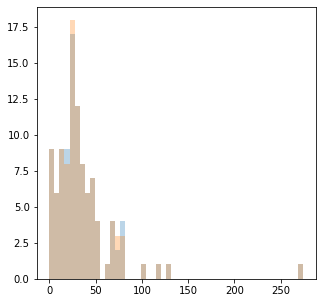

In [15]:
plt.figure(figsize=(5,5))
plt.hist(bind[0].numpy(), bins=50, alpha=0.3)
plt.hist(dissociate[0].numpy(), bins=50, alpha=0.3)
#plt.xlim(0,60)
plt.show()

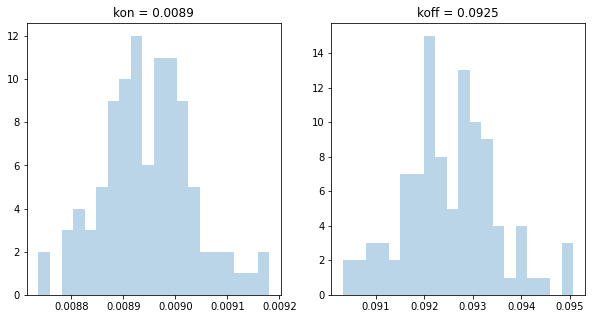

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(a01.flatten().numpy(), bins=20, alpha=0.3)
plt.title("kon = {:.4f}".format(a01.mean()))
plt.subplot(1,2,2)
plt.hist(a10.flatten().numpy(), bins=20, alpha=0.3)
plt.title("koff = {:.4f}".format(a10.mean()))
plt.show()

Let's find and remove high-frequency traces

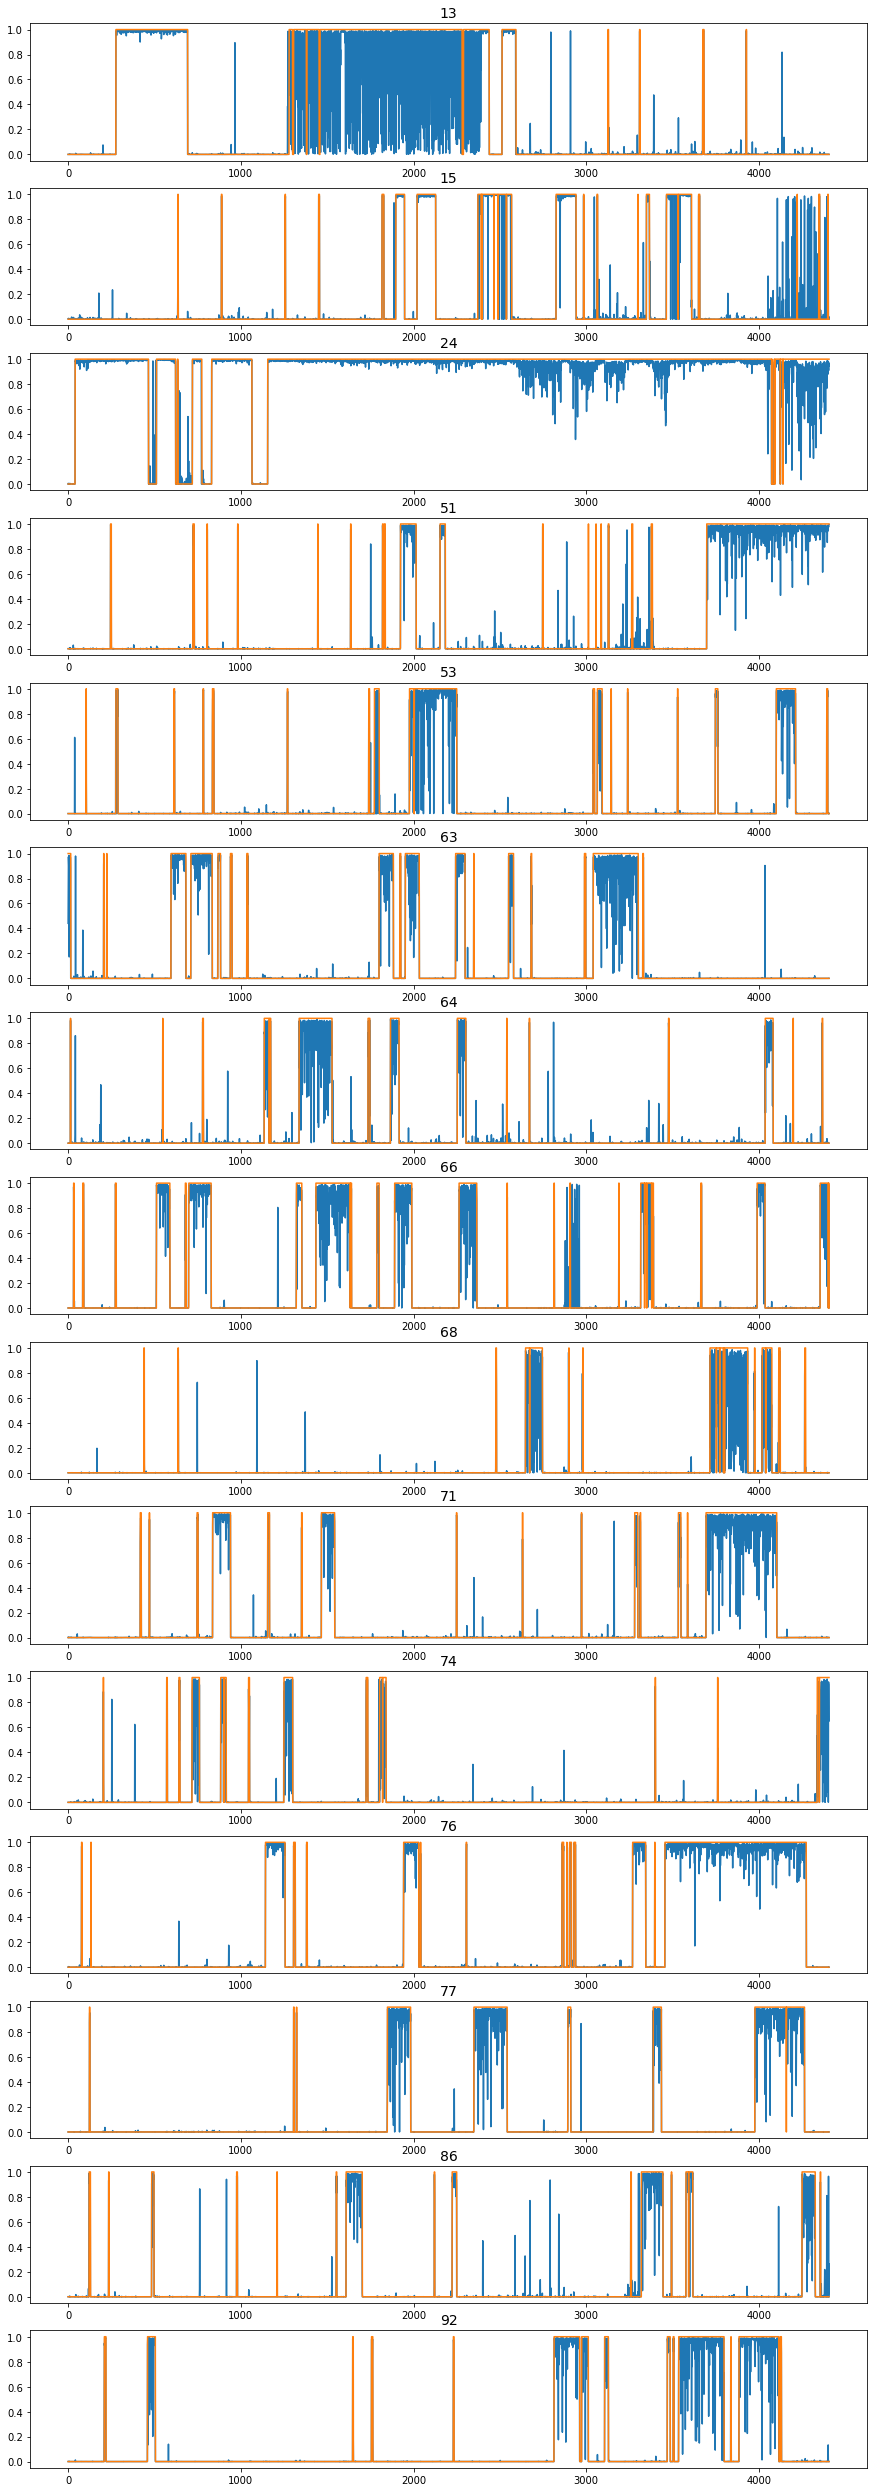

In [17]:
high_frequency = torch.nonzero(bind[0] > 60).squeeze()
r = len(high_frequency) + 1
plt.figure(figsize=(15,3*r))
for i, n in enumerate(high_frequency):
    plt.subplot(r,1,i+1)
    plt.title(n.item(), fontsize=14)
    plt.plot(model.z_marginal[n])
    plt.plot(model.data.labels["z"][n])
plt.show()

In [18]:
low_frequency = torch.nonzero(bind[0] <= 60).squeeze()
a01 = ((1 - samples[:, low_frequency, :-1]) * samples[:, low_frequency, 1:] / (1-samples[:, low_frequency, :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))
a10 = ((samples[:, low_frequency, :-1]) * (1 - samples[:, low_frequency, 1:]) / (samples[:, low_frequency, :-1]).sum((-2,-1), keepdim=True)).sum((-2,-1))

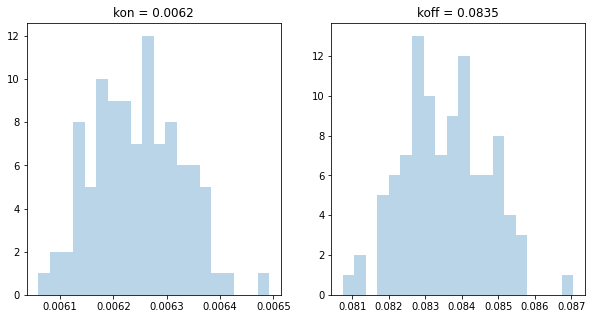

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(a01.flatten().numpy(), bins=20, alpha=0.3)
plt.title("kon = {:.4f}".format(a01.mean()))
plt.subplot(1,2,2)
plt.hist(a10.flatten().numpy(), bins=20, alpha=0.3)
plt.title("koff = {:.4f}".format(a10.mean()))
plt.show()

Now let's see how real data kinetics compares to the simulated kinetics from the best fit

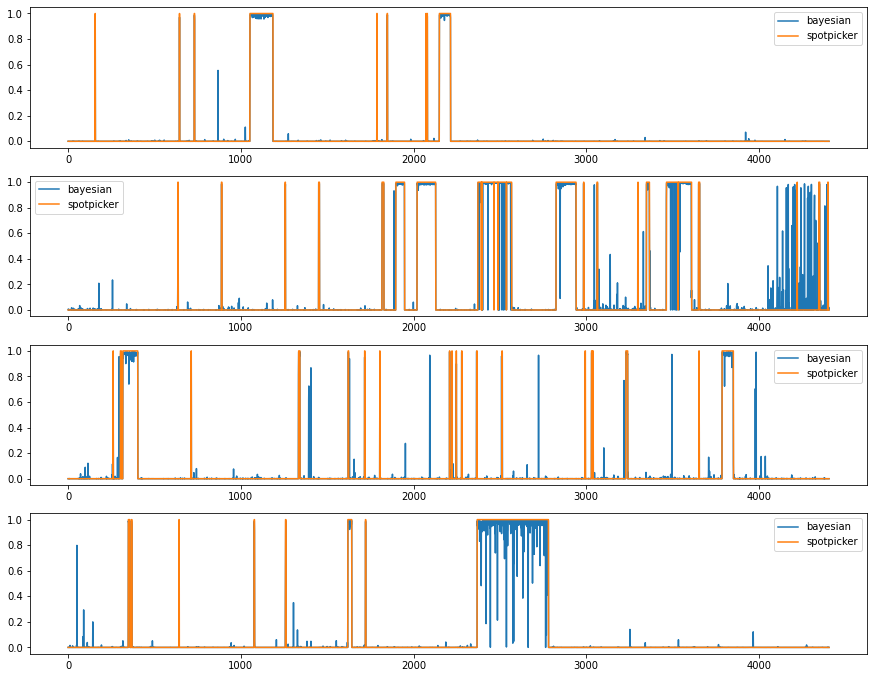

In [20]:
# look at 5, 15, 30, 35
examples = [5, 15, 30, 35]
r = len(examples) + 1
plt.figure(figsize=(15,3*r))
for i, n in enumerate(examples):
    plt.subplot(r,1,i+1)
    plt.plot(model.z_marginal[n], label="bayesian")
    plt.plot(model.data.labels["z"][n], label="spotpicker")
    plt.legend()
plt.show()

### Simulated trace

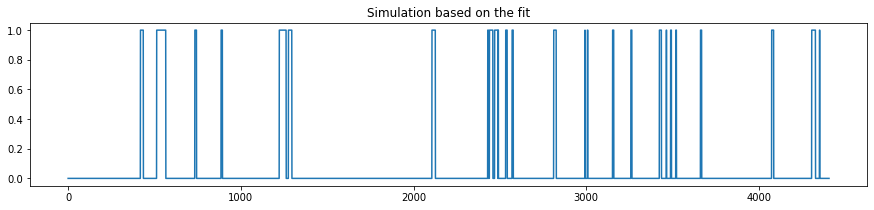

In [21]:
A = torch.tensor([[1-a01.mean(), a01.mean()], [a10.mean(), 1-a10.mean()]])

x = torch.zeros(model.data.F)
for i in range(1,model.data.F):
    x[i] = dist.Bernoulli(A[x[i-1].long()][1]).sample().item()

plt.figure(figsize=(15,3))
plt.title("Simulation based on the fit")
plt.plot(x)
plt.show()

### Spotpicker sorted rastergram

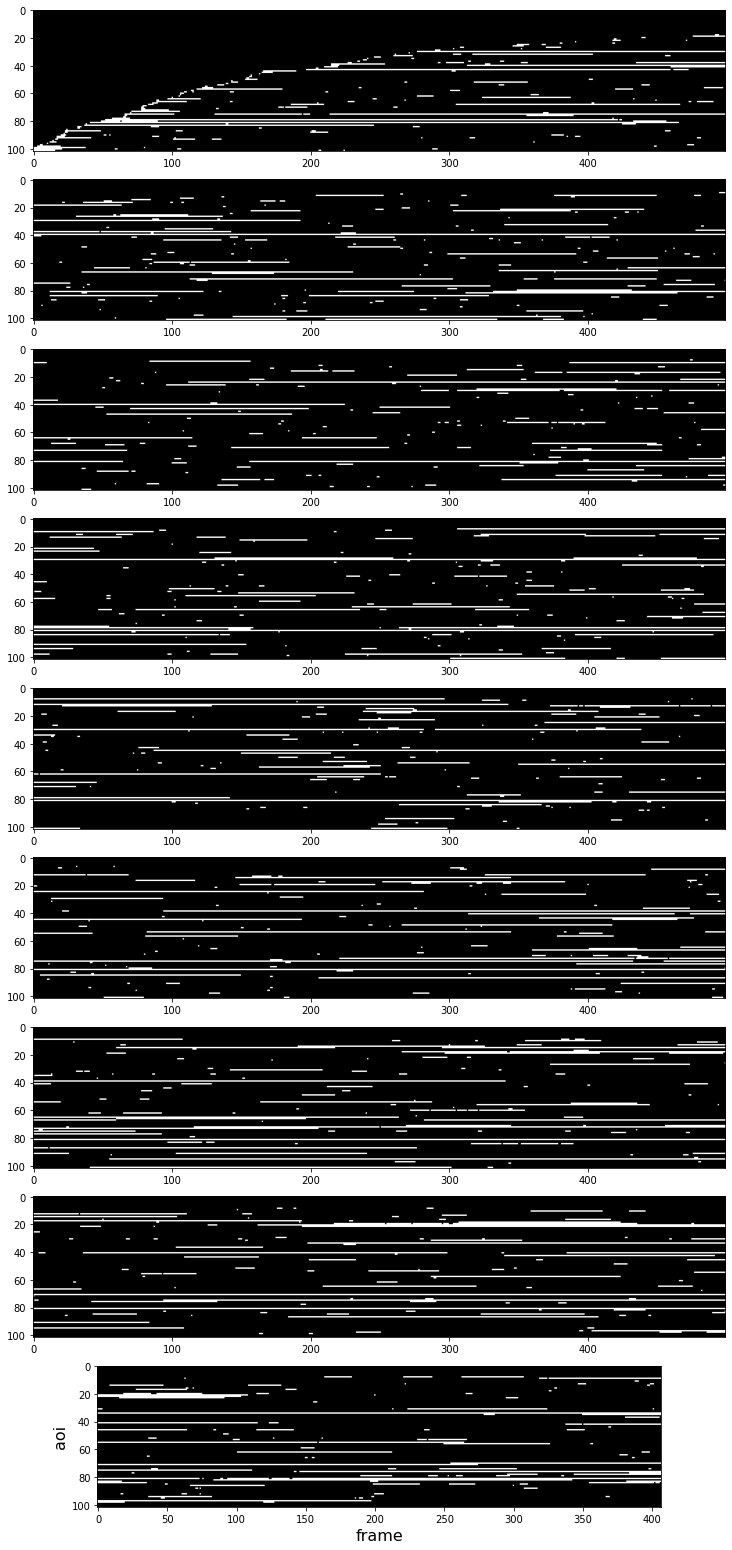

In [22]:
frames = np.arange(1, model.data.F+1)
q1 = np.ones((model.data.N, model.data.F))
q1[:, :-1] = model.data.labels["z"][:, 1:]
cumq0 = np.cumprod(1 - model.data.labels["z"], axis=-1)
sttfb = (frames * q1 * cumq0).sum(-1)
sdx = np.flip(np.argsort(sttfb))

r = model.data.F // 500 + 1
figsize = torch.tensor([15, model.data.N * r * 15. / 500])
plt.figure(figsize=figsize)
for i in range(r):
    plt.subplot(r,1,i+1)
    plt.imshow(model.data.labels["z"][sdx, i*500:(i+1)*500], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

### Differences

In [21]:
mask = (((model.data.labels["z"] == 0) & (model.z_marginal.numpy() > 0.5)))
n, f = np.nonzero(mask)
np.unique(n, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,
         14,  15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         55,  56,  57,  58,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
         82,  83,  84,  85,  86,  87,  88,  89,  91,  92,  93,  94,  96,
         97,  98,  99, 100, 101]),
 array([ 8,  4,  6,  7,  3,  1,  2,  3,  3,  5,  2,  1, 23, 36, 42,  8,  2,
         4,  3,  2,  1, 22,  9,  2,  7,  8,  2,  6, 15,  6,  2,  5,  3,  5,
         7,  3, 10,  4, 10,  5,  4,  3,  6,  7, 32,  3,  7,  1,  8,  7,  7,
         6, 11,  4,  5,  1,  1,  1,  5,  3,  9,  3,  8,  7, 22,  5,  3,  6,
         1,  7, 14,  2,  1,  5,  4,  2,  1,  1,  4,  3,  2,  5, 24,  1,  5,
         6,  2,  3,  3,  8,  1,  8,  8,  2,  9,  5]))

In [23]:
mask = (((model.data.labels["z"] == 1) & (model.z_marginal.numpy() < 0.5)))
n, f = np.nonzero(mask)
np.unique(n, return_counts=True)

(array([  0,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
         55,  56,  57,  58,  60,  62,  63,  64,  66,  67,  68,  69,  70,
         71,  73,  74,  75,  76,  77,  78,  79,  82,  83,  85,  86,  87,
         88,  89,  92,  93,  94,  96,  97,  98,  99, 100, 101]),
 array([  3,   3,  12,   6,   2,   6,   1,   1,  15,   9,   3, 315,  93,
          7,   1,   4,   6,   5,   7,   6,  24,  45,   9,   3,   4,   7,
          6,   7,   6,   2,   7,   1,  25,   1,   7,   3,   4,   7,  24,
          4,   5,  10,   5,   3,  22,   6,   5,   4,   9,   9,  24,   4,
          1,   2,   4,   6,   5,   7,   6,   7,  28,   3,  23,   4,   6,
          6,   4,  10,   4,   2,  14,  21,   9,   8,   5,   2,  11,   5,
         10,   5,  34,   6,   8,   6,   4,   9,   5,   4,  

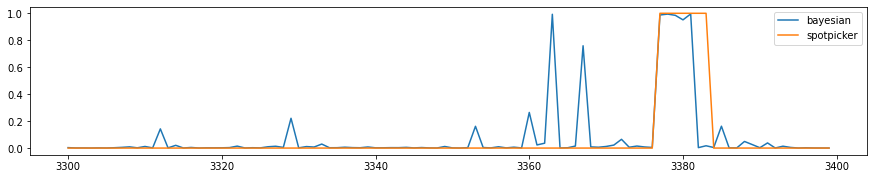

In [24]:
# look at 5, 15, 30, 35
examples = [51]
r = len(examples) + 1
plt.figure(figsize=(15,3*r))
for i, n in enumerate(examples):
    plt.subplot(r,1,i+1)
    f1 = 3300
    f2 = 3400
    plt.plot(torch.arange(f1, f2), model.z_marginal[n, f1:f2], label="bayesian")
    plt.plot(torch.arange(f1, f2), model.data.labels["z"][n, f1:f2], label="spotpicker")
    #plt.plot(torch.arange(model.data.F), model.z_marginal[n], label="bayesian")
    #plt.plot(torch.arange(model.data.F), model.data.labels["z"][n], label="spotpicker")
    plt.legend()
plt.show()

## Appendix

$$ p(\mathbf{z}) = \prod_{n=0}^{N-1} p(z_{n,0}|\pi) \prod_{f=1}^{F-1} p(z_{n,f}|z_{n,f-1}, A) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( \log p(z_{n,0}|\pi) + \sum_{f=1}^{F-1} \log p(z_{n,f}|z_{n,f-1}, A_{01}, A_{10}) \right ) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( (1-z_{n,0}) \log (1-\pi) + z_{n,0} \log \pi +
    \sum_{f=1}^{F-1} \left (
        (1 - z_{n,f-1}) (1 - z_{n,f}) \log (1 - \frac{A_{01}}{2})
        + (1-z_{n,f-1}) z_{n,f} \log \frac{A_{01}}{2}
        + z_{n,f-1} (1 - z_{n,f}) \log \frac{1+A_{10}}{2}
        + z_{n,f-1} z_{n,f} \log (1 - A_{10}) \right ) \right ) $$

$$ \log p(\mathbf{z}) = \sum_{n=0}^{N-1} \left ( (1-z_{n,0}) \log (1-\pi) + z_{n,0} \log \pi +
    \sum_{f=1}^{F-1} \left (
        (1 - z_{n,f-1}) (1 - z_{n,f}) \log (1 - A_{01})
        + (1-z_{n,f-1}) z_{n,f} \log A_{01}
        + z_{n,f-1} (1 - z_{n,f}) \log A_{10}
        + z_{n,f-1} z_{n,f} \log (1 - A_{10}) \right ) \right ) $$

$$ \dfrac{\partial \log p(\mathbf{z})}{\partial \pi}
 = \sum_{n=0}^{N-1} \left ( -\dfrac{1-z_{n,0}}{1-\pi} + \dfrac{z_{n,0}}{\pi} \right ) = 0 $$
 
$$ \sum_{n=0}^{N-1} \left ( \dfrac{(1-\pi) z_{n,0} - \pi (1-z_{n,0})}{\pi (1-\pi)} \right ) = 0 $$

$$ \dfrac{\partial \log p(\mathbf{z})}{\partial A_{01}}
 = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \left (
     \dfrac{-(1-z_{n,f-1})(1-z_{n,f})}{1-A_{01}}
     + \dfrac{(1-z_{n,f-1})z_{n,f}}{A_{01}} \right ) = 0 $$

$$ \sum_{n=0}^{N-1} \left ( z_{n,0} - \pi \right ) = 0 $$

$$ \pi = \dfrac{1}{N} \sum_{n=0}^{N-1} z_{n,0} $$

$$ \mathbb{E}_{q(\mathbf{z})} \left [ \pi \right ] = \dfrac{1}{N} \sum_{n=0}^{N-1} q(z_{n,0}=1) $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \left ( (1-A_{01}) (1-z_{n,f-1})z_{n,f} - A_{01} (1-z_{n,f-1})(1-z_{n,f}) \right ) = 0 $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) z_{n,f} - \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) A_{01} = 0 $$

$$ \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) z_{n,f} = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} (1-z_{n,f-1}) A_{01} $$

$$ A_{01} = \sum_{n=0}^{N-1} \sum_{f=1}^{F-1} \dfrac{(1-z_{n,f-1}) z_{n,f}}{\sum_{n^\prime=0}^{N-1} \sum_{f^\prime=1}^{F-1} (1-z_{n^\prime,f^\prime-1})} $$

$$ A_{10} = \dfrac{\sum_n^N \sum_f^F z_{n,f} (1-z_{n,f+1})}{\sum_n^N \sum_f^F z_{n,f}} $$

$$ \mathbb{E}_{q(\mathbf{z})} \left [ A_{01} \right ]
    = \sum_\mathbf{z} \sum_n^N \sum_f^F \dfrac{(1-z_{n,f}) z_{n,f+1}}{\sum_{n^\prime}^N \sum_{f^\prime}^F (1-z_{n^\prime,f^\prime})} q(\mathbf{z}) $$

$$  = \sum_n^N \sum_f^F q(z_{n,f}=0) q(z_{n,f+1}=1) \sum_{\mathbf{z} \backslash z_{n,f},z_{n,f+1}}
    \dfrac{1}{1 + 0 + \sum_{n^\prime}^N \sum_{f^\prime}^F (1-z_{n^\prime,f^\prime})} q(\mathbf{z}) $$